In [58]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, auc, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Preprocess

In [17]:
cancer_df = pd.read_csv('./CANCER_TABLE.csv')
cancer_df.head()

,diameter (cm),cancer
0,6.309685,False
1,4.580894,False
2,6.310071,False
3,7.495139,False
4,2.216181,False


In [18]:
cancer_df['marvel_sabres_pred'] = cancer_df['diameter (cm)'].apply(lambda x: True if x > 7 else False)
cancer_df.head()

,diameter (cm),cancer,marvel_sabres_pred
0,6.309685,False,False
1,4.580894,False,False
2,6.310071,False,False
3,7.495139,False,True
4,2.216181,False,False


In [19]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   diameter (cm)       1000 non-null   float64
 1   cancer              1000 non-null   bool   
 2   marvel_sabres_pred  1000 non-null   bool   
dtypes: bool(2), float64(1)
memory usage: 9.9 KB


## Evaluation Metrics

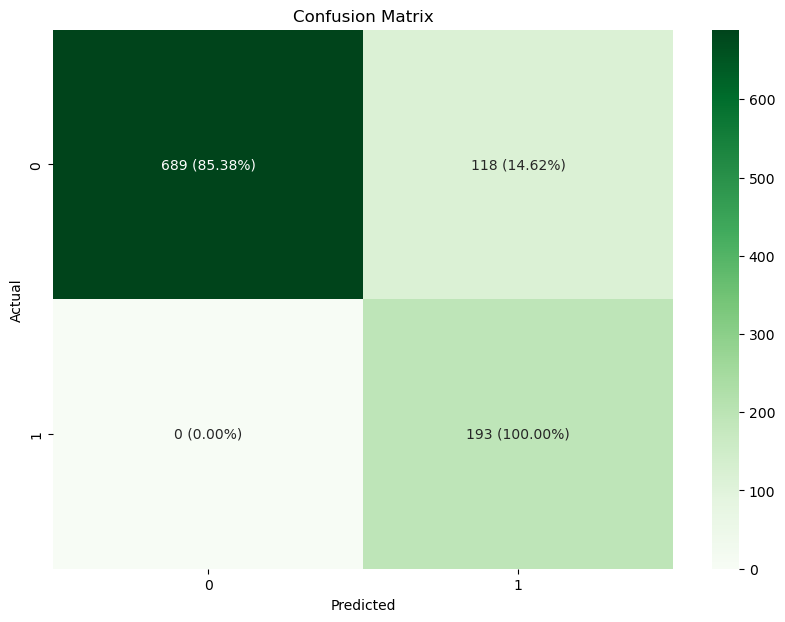

In [31]:
conf_matrix = confusion_matrix(cancer_df['cancer'], cancer_df['marvel_sabres_pred'])
conf_matrix_percents = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
annotations = np.array([f"{count} ({percent:.2f}%)" for count, percent in zip(conf_matrix.flatten(), conf_matrix_percents.flatten())])
annotations = annotations.reshape(conf_matrix.shape)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"TPR: {tpr:.2f}")
print(f"FPR: {fpr:.2f}")

TPR: 1.00
FPR: 0.15


In [34]:
accuracy = accuracy_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred'])
precision = precision_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred'])
recall = recall_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred'])
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.88
Precision: 0.62
Recall: 1.00


In [35]:
f1 = f1_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred'])
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.77


## Logistic Regression 

In [47]:
model = LogisticRegression()
X = cancer_df['diameter (cm)'].values.reshape(-1, 1)
model.fit(X, cancer_df['cancer'])
y_proba = model.predict_proba(X)[:, 1]
cancer_df['marvel_sabres_proba'] = y_proba
cancer_df.head()

,diameter (cm),cancer,marvel_sabres_pred,marvel_sabres_proba,marvel_sabres_pred_upgraded
0,6.309685,False,False,5.338072e-05,False
1,4.580894,False,False,2.847031e-09,False
2,6.310071,False,False,5.349834e-05,False
3,7.495139,False,True,4.346800e-02,False
4,2.216181,False,False,4.069849e-15,False


In [48]:
def calculate_metrics(y_true, y_proba, threshold=0.5):
    positive_predictions = y_proba >= threshold
    negative_predictions = ~positive_predictions
    tp = (positive_predictions & y_true).sum()
    tn = (negative_predictions & ~y_true).sum()
    fp = (positive_predictions & ~y_true).sum()
    fn = (negative_predictions & y_true).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

def generate_roc_curve(y_true, y_proba):
    thresholds = np.linspace(0, 1, 100)
    tpr_arr = []
    fpr_arr = []
    for threshold in thresholds:
        tpr, fpr = calculate_metrics(y_true, y_proba, threshold)
        tpr_arr.append(tpr)
        fpr_arr.append(fpr)
    return tpr_arr, fpr_arr

def draw_roc_curve(tpr_arr, fpr_arr):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_arr, tpr_arr, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


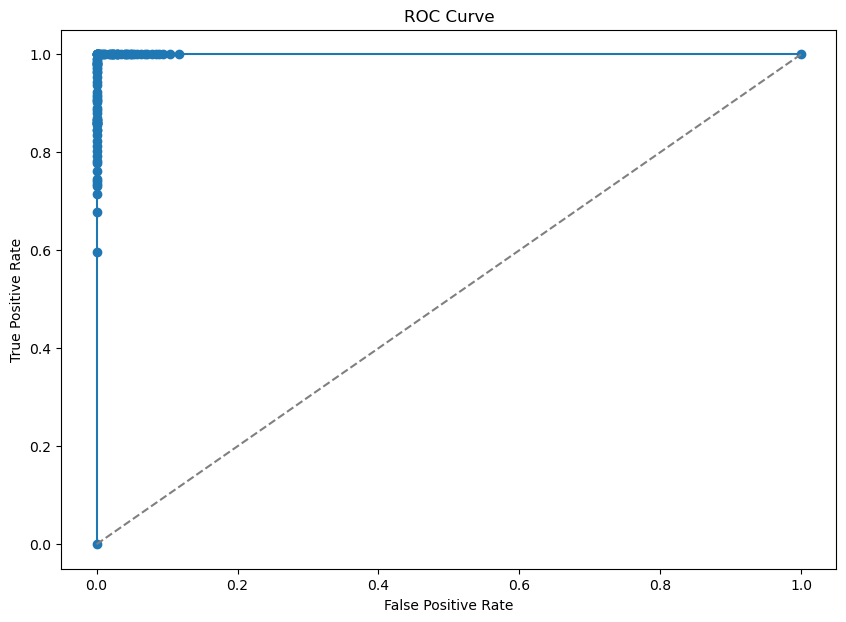

In [49]:
tpr_arr, fpr_arr = generate_roc_curve(cancer_df['cancer'], cancer_df['marvel_sabres_proba'])
draw_roc_curve(tpr_arr, fpr_arr)

In [50]:
def find_best_threshold(tpr_arr, fpr_arr, thresholds):
    tpr_fpr_sub = np.array(tpr_arr) - np.array(fpr_arr)
    best_threshold_index = np.argmax(tpr_fpr_sub)
    best_threshold = thresholds[best_threshold_index]
    return best_threshold

# Generate thresholds
thresholds = np.linspace(0, 1, 100)

# Find the best threshold
best_threshold = find_best_threshold(tpr_arr, fpr_arr, thresholds)
print(f"Best Threshold: {best_threshold:.2f}")

Best Threshold: 0.42


In [53]:
auc_score = auc(fpr_arr, tpr_arr)
print(f"AUC: {auc_score:.2f}")

AUC: 1.00


In [54]:
cancer_df['marvel_sabres_pred_upgraded'] = (cancer_df['marvel_sabres_proba'] >= best_threshold)
cancer_df.head()

,diameter (cm),cancer,marvel_sabres_pred,marvel_sabres_proba,marvel_sabres_pred_upgraded
0,6.309685,False,False,5.338072e-05,False
1,4.580894,False,False,2.847031e-09,False
2,6.310071,False,False,5.349834e-05,False
3,7.495139,False,True,4.346800e-02,False
4,2.216181,False,False,4.069849e-15,False


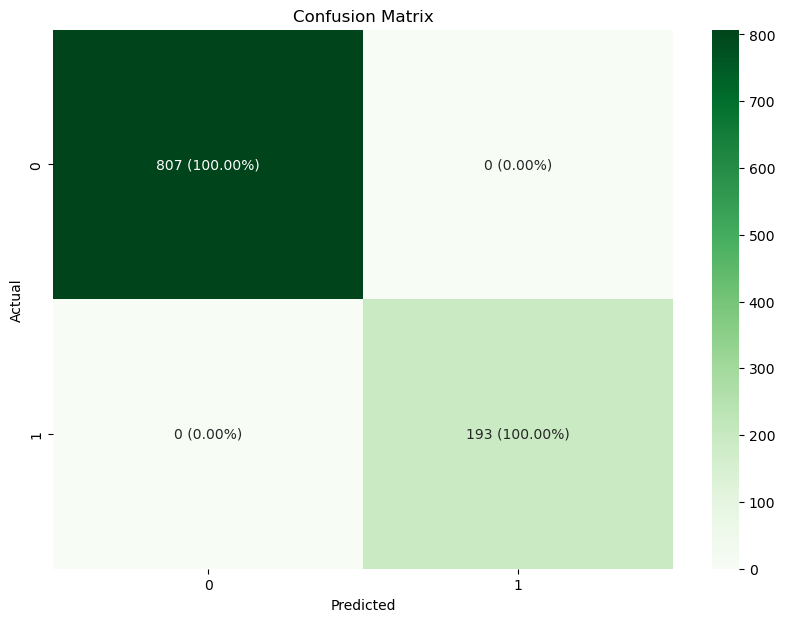

In [55]:
conf_matrix = confusion_matrix(cancer_df['cancer'], cancer_df['marvel_sabres_pred_upgraded'])
conf_matrix_percents = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
annotations = np.array([f"{count} ({percent:.2f}%)" for count, percent in zip(conf_matrix.flatten(), conf_matrix_percents.flatten())])
annotations = annotations.reshape(conf_matrix.shape)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [56]:
accuracy = accuracy_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred_upgraded'])
precision = precision_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred_upgraded'])
recall = recall_score(cancer_df['cancer'], cancer_df['marvel_sabres_pred_upgraded'])
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00


In [57]:
tp, fp, fn, tn = conf_matrix.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"TPR: {tpr:.2f}")
print(f"FPR: {fpr:.2f}")

TPR: 1.00
FPR: 0.00


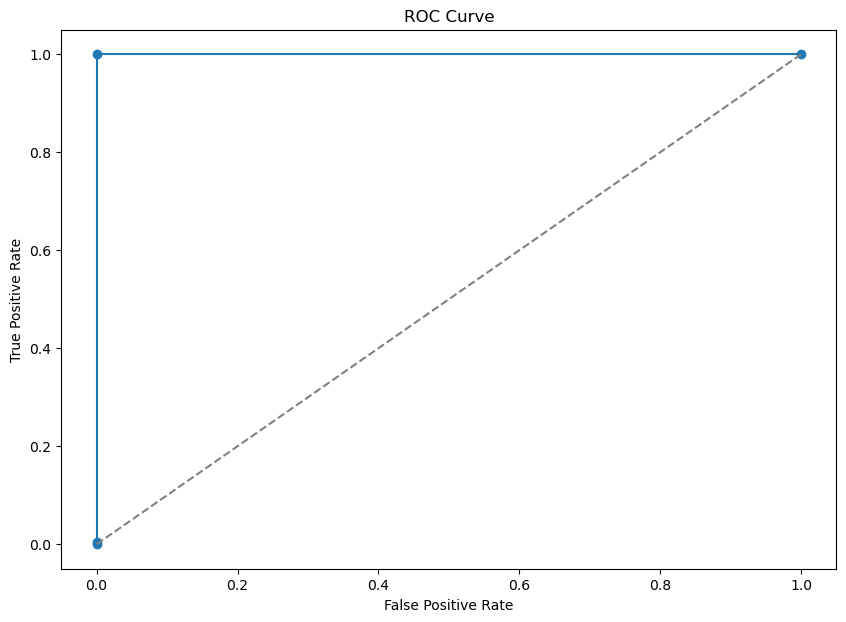

In [64]:
fpr, tpr, thresholds = roc_curve(cancer_df['cancer'], cancer_df['marvel_sabres_proba'])
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [61]:
thresholds

array([           inf, 9.99985397e-01, 4.84559899e-01, 1.89865175e-20])